<a href="https://colab.research.google.com/github/jgraving/deepposekit/blob/master/examples/step4a_initialize_annotations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# DeepPoseKit Step 4a - Initialize annotations

This is step 4a of the example notebooks for using DeepPoseKit. This notebook shows you how to use your trained model to initialize the keypoint labels for the unannotated images in your annotation set.

**NOTE**: If you run into problems, you can help us improve DeepPoseKit by [opening an issue](https://github.com/jgraving/deepposekit/issues/new) or [submitting a pull request](https://help.github.com/en/articles/creating-a-pull-request-from-a-fork)

**If you're using Colab**: make sure to go to the “Runtime” dropdown menu, select “Change runtime type” and select `GPU` in the "Hardware accelerator" drop-down menu


If you haven't already installed DeepPoseKit you can run the next cell

In [ ]:
import sys
!{sys.executable} -m pip install -U deepposekit

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob

from deepposekit.models import load_model
from deepposekit.io import DataGenerator, ImageGenerator

from os.path import expanduser

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

HOME = expanduser("~") if not IN_COLAB else '.'

Find the saved models

In [2]:
models = sorted(glob.glob(HOME + '/Documents/programming/my_data_spider/*model*.h5'))
models

['/home/urs/Documents/programming/my_data_spider/best_model_StackedDenseNet.h5',
 '/home/urs/Documents/programming/my_data_spider/best_model_cropped_StackedDenseNet.h5']

Find the annotation sets

In [3]:
annotations = sorted(glob.glob(HOME + '/Documents/programming/my_data_spider/*annotation*.h5'))
annotations

['/home/urs/Documents/programming/my_data_spider/spider_annotation_set.h5',
 '/home/urs/Documents/programming/my_data_spider/spider_cropped_annotation_set.h5']

# Load the trained model

This loads the trained model into memory for making predictions

In [4]:
model = load_model(HOME + '/Documents/programming/my_data_spider/best_model_cropped_StackedDenseNet.h5')

# Initialize unannotated data

This creates a `DataGenerator` instance for loading the data, which is then wrapped in an `ImageGenerator`. `ImageGenerator` is then passed to the model for initializing the unannotated keypoints with predictions from a previously-trained model the image data. See the doc string for details:

In [5]:
DataGenerator?

Init signature: DataGenerator(datapath, dataset='images', mode='annotated', **kwargs)
Docstring:     
Creates a data generator for accessing an annotation set.

Parameters
----------
datapath : str
    The path to the annotations file. Must be .h5
    e.g. '/path/to/file.h5'
dataset : str
    The key for the image dataset in the annotations file.
    e.g. 'images'
mode : str
    The mode for loading and saving data.
    Must be 'unannotated', 'annotated', or "full"
Init docstring:
Initializes the BaseGenerator class.
If graph and swap_index are not defined,
they are set to a vector of -1 corresponding
to keypoints shape
File:           ~/anaconda3/envs/DeepPoseKit/lib/python3.7/site-packages/deepposekit/io/DataGenerator.py
Type:           type
Subclasses:     


In [6]:
ImageGenerator?

Init signature: ImageGenerator(generator, **kwargs)
Docstring:     
Creates a wrapper for generating images from a data generator.

Parameters
----------
generator: deepposekit.io.BaseGenerator
    An instance of BaseGenerator (deepposekit.io.BaseGenerator) object.
    The output of the generator must be `(images, keypoints)`, where images
    are a numpy array of shape (n_images, height, width, channels), and 
    keypoints are a numpy array of shape (n_images, n_keypoints, 2), where
    2 is the row, column coordinates of the keypoints in each image.
Init docstring:
Initializes the BaseGenerator class.
If graph and swap_index are not defined,
they are set to a vector of -1 corresponding
to keypoints shape
File:           ~/anaconda3/envs/DeepPoseKit/lib/python3.7/site-packages/deepposekit/io/ImageGenerator.py
Type:           type
Subclasses:     


Let's initialize our `spider_annotation_set.h5` from Step 1

In [5]:
data_generator = DataGenerator(HOME + '/Documents/programming/my_data_spider/spider_cropped_annotation_set.h5', mode='unannotated')
image_generator = ImageGenerator(data_generator)

/home/urs/anaconda3/envs/DeepPoseKit/lib/python3.7/site-packages/deepposekit/io/DataGenerator.py:81: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.annotated = np.all(h5file["annotated"].value, axis=1)


This passes the data generator to the model to get the predicted coordinates

In [6]:
predictions = model.predict(image_generator, verbose=1)

36/36 [==============================] - 5s 142ms/step


In [7]:
predictions.shape

(36, 26, 3)

This saves the predicted coordinates as initial keypoint locations for the unannotated data

In [8]:
data_generator[:] = predictions

Indexing the generator, e.g. `data_generator[0]` returns an image-keypoints pair, which you can then visualize. 

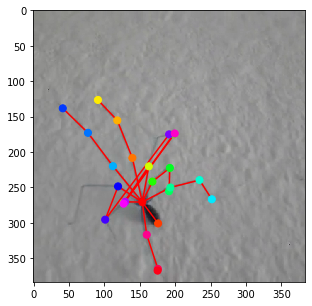

In [9]:
image, keypoints = data_generator[0]

plt.figure(figsize=(5,5))
image = image[0] if image.shape[-1] is 3 else image[0, ..., 0]
cmap = None if image.shape[-1] is 3 else 'gray'
plt.imshow(image, cmap=cmap, interpolation='none')
for idx, jdx in enumerate(data_generator.graph):
    if jdx > -1:
        plt.plot(
            [keypoints[0, idx, 0], keypoints[0, jdx, 0]],
            [keypoints[0, idx, 1], keypoints[0, jdx, 1]],
            'r-'
        )
plt.scatter(keypoints[0, :, 0], keypoints[0, :, 1], c=np.arange(data_generator.keypoints_shape[0]), s=50, cmap=plt.cm.hsv, zorder=3)

plt.show()